In [1]:
%matplotlib inline

# Preprocessing and Spike Sorting Tutorial

# Chapter 1: Importing Recording Data and Metadata

In [2]:
import os
import warnings
import glob
import pickle
import _pickle as cPickle
import imp

/nancy/user/riwata/projects/spike_sorting/bin/conda_environments/env/spike_interface_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  


In [3]:
from collections import defaultdict
import time
import json

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import scipy.signal

In [5]:
# Changing the figure size
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

The spikeinterface module by itself import only the spikeinterface.core submodule
which is not useful for end user



In [6]:
import spikeinterface

We need to import one by one different submodules separately (preferred).
There are 5 modules:

- :code:`extractors` : file IO
- :code:`toolkit` : processing toolkit for pre-, post-processing, validation, and automatic curation
- :code:`sorters` : Python wrappers of spike sorters
- :code:`comparison` : comparison of spike sorting output
- :code:`widgets` : visualization



In [7]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [8]:
import spikeinterface.core

We can also import all submodules at once with this
  this internally import core+extractors+toolkit+sorters+comparison+widgets+exporters

This is useful for notebooks but this is a more heavy import because internally many more dependency
are imported (scipy/sklearn/networkx/matplotlib/h5py...)



In [9]:
import spikeinterface.full as si

In [10]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (10,6)

# Part 1: Importing Data

In [20]:
remote_path = "mearec/mearec_test_10s.h5"

In [21]:
local_path = si.download_dataset(remote_path=remote_path)

In [12]:
recording, sorting_true = se.read_mearec(local_path)

In [13]:
type(recording)

spikeinterface.extractors.neoextractors.mearec.MEArecRecordingExtractor

## Plotting the electrophysiology activity

:code:`recording` is a :code:`RecordingExtractor` object, which extracts information about channel ids, channel locations
(if present), the sampling frequency of the recording, and the extracellular  traces. :code:`sorting_true` is a
:code:`SortingExtractor` object, which contains information about spike-sorting related information,  including unit ids,
spike trains, etc.
Let's use the :code:`widgets` module to visualize the traces and the raster plots.



- Plotting the activity for all channels for the first 5 seconds
    - Check to see if there's any activity.
    - You can adjust the time by changing `time_range=(0, 5)`. The first number is when the plotting starts in seconds, and the second number is the when the plotting ends.

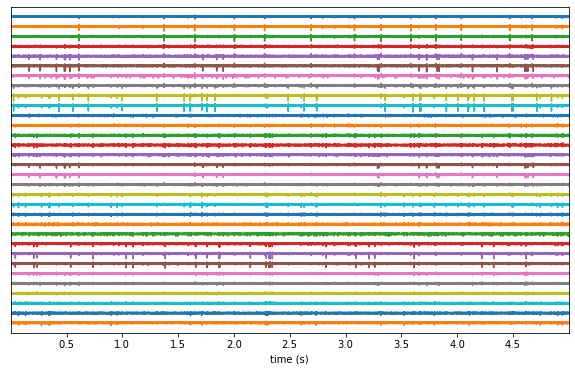

In [14]:
w_ts = sw.plot_timeseries(recording, time_range=(0, 5))


## Metadata from the recording file

This is how you retrieve info from a :code:`RecordingExtractor`...



In [15]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()
duration = recording.get_num_frames()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)
print('Duration:', duration)
print('Number of hours:', duration/fs/3600)

Channel ids: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32']
Sampling frequency: 32000.0
Number of channels: 32
Number of segments: 1
Duration: 320000
Number of hours: 0.002777777777777778


:code:`spikeinterface` internally uses the :code:`probeinterface`
to handle Probe and ProbeGroup.
 So any probe in the probeinterface collections can be download
and set to a Recording object.
In this case, the MEArec dataset already handles a Probe and we don't need to set it.



...and a :code:`SortingExtractor`



Using the :code:`toolkit`, you can perform preprocessing on the recordings.
Each pre-processing function also returns a :code:`RecordingExtractor`,
which makes it easy to build pipelines. Here, we filter the recording and
apply common median reference (CMR).
All theses preprocessing steps are "lazy". The computation is done on demand when we call
`recording.get_traces(...)` or when we save the object to disk.



# Part 2: Setting Probes

In [17]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [16]:
probe = recording.get_probe()

(<matplotlib.collections.PolyCollection at 0x7f0a8a616cd0>,
 <matplotlib.collections.PolyCollection at 0x7f0a8a6166d0>)

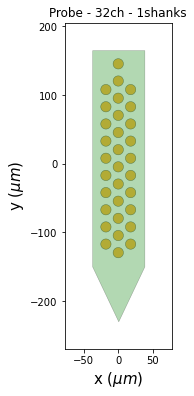

In [18]:
plot_probe(probe)

# Saving the Recording Files for the Next Notebook

- Creating an output folder based on the recording file name

In [22]:
recording_file_name = os.path.basename(remote_path)
recording_file_root = os.path.splitext(recording_file_name)[0]

In [23]:
recording_file_root

'mearec_test_10s'

- Alternatively, you can use the file name provided by the metadata file or the experiment name in the parameter file
    - If you want to use either of these, you must make the boxes below into a code block

In [24]:
parent_output_directory = "./proc/{}".format(recording_file_root)

In [25]:
parent_output_directory

'./proc/mearec_test_10s'

In [26]:
os.makedirs(parent_output_directory, exist_ok=True)

In [27]:
recording_output_directory = os.path.join(parent_output_directory, "recording_raw")


In [28]:
recording_output_directory

'./proc/mearec_test_10s/recording_raw'

In [29]:
if not os.path.exists(recording_output_directory):
    recording.save_to_folder(name="recording_raw", folder=recording_output_directory)
else:
    warnings.warn("""Directory already exists for: {}. 
    Either continue on if you are satisfied with the previous run 
    or delete the directory and run this cell again""".format(recording_output_directory))

write_binary_recording with n_jobs 1  chunk_size None


## Looking at the LFP

In [48]:
import numpy as np
import matplotlib.pylab as plt
import scipy.signal

In [49]:
recording_lfp = recording.channel_slice(channel_ids=["14", "15"])

In [50]:
recording_lfp = st.preprocessing.bandpass_filter(recording_lfp, freq_min=1, freq_max=300)

In [51]:
recording_lfp = st.preprocessing.resample(recording_lfp, 1000)

AttributeError: module 'spikeinterface.toolkit.preprocessing' has no attribute 'resample'

In [ ]:
f_lfp, p_lfp = scipy.signal.welch(recording_lfp.get_traces(), fs=recording_lfp.get_sampling_frequency())

In [ ]:
fig, ax = plt.subplots()
ax.semilogy(f_lfp, p_lfp[0])